In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ortools_solver import CVRP_solver
from utils import random_choose_candidate, distance_calculator, calculate_distance_matrix, show_matrix, get_optimized_sequence, print_command
from QAP_solver import calculate_T, CVRP_QAP
import pygmtools as pygm

/u/yq/chem1906/anaconda3/envs/pipette_scheduling/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def generate_diagonal_matrix(n=72):
    # n = number of diagonal 8*8 matrix in the 96*96 matrix
    a = np.zeros((96,96))
    # randomly pick n number from 0 to 144
    picked_submatrix = np.random.choice(144, n, replace=False)
    n = 0
    for i in range(12):
        for j in range(12):
            if n in picked_submatrix:
                a[i*8:(i+1)*8, j*8:(j+1)*8] = np.eye(8)
            n += 1
    show_matrix(a)
    return a

In [ ]:
def swap_columns(matrix, col1, col2):
        matrix[:, [col1, col2]] = matrix[:, [col2, col1]]

def adding_noise(matrix, iteration=3):
    column_permutation = np.eye(96)
    # pick an integer from 0 to 10 with gaussian distribution
    for i in range(iteration):
        num_permutation = np.random.normal(5, 2)
        num_permutation = int(num_permutation)
        # randomly swipe two columns n times
        for i in range(num_permutation):
            exchange_columns = np.random.choice(96, 2, replace=False)
            swap_columns(column_permutation, exchange_columns[0], exchange_columns[1])
    show_matrix(column_permutation)
    permuted_matrix = np.dot(matrix, column_permutation)
    return permuted_matrix


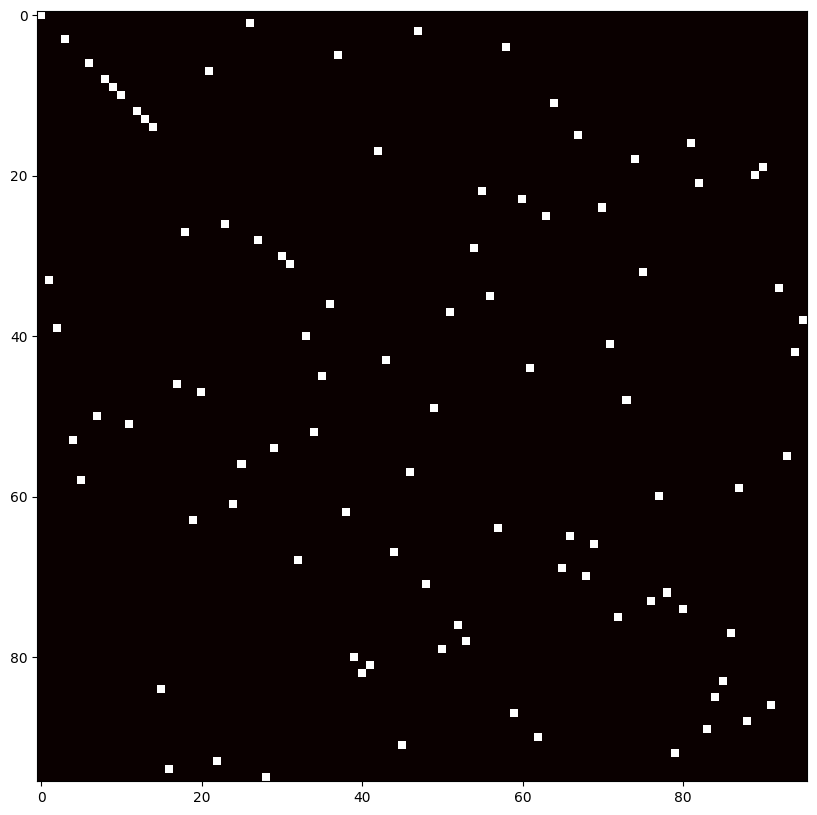

In [19]:
column_permutation = np.eye(96)
# Function to swap two columns in a matrix
def swap_columns(matrix, col1, col2):
    matrix[:, [col1, col2]] = matrix[:, [col2, col1]]

# pick an integer from 0 to 10 with gaussian distribution
for i in range(20):
    num_permutation = np.random.normal(5, 2)
    num_permutation = int(num_permutation)
    # randomly swipe two columns n times
    for i in range(num_permutation):
        exchange_columns = np.random.choice(96, 2, replace=False)
        swap_columns(column_permutation, exchange_columns[0], exchange_columns[1])
show_matrix(column_permutation)

Epoch 1/20, Loss: -0.0002, Avg Reward: -0.0047
Epoch 2/20, Loss: -0.0001, Avg Reward: -0.0047
Epoch 3/20, Loss: 0.0002, Avg Reward: -0.0047
Epoch 4/20, Loss: -0.0002, Avg Reward: -0.0047
Epoch 5/20, Loss: 0.0001, Avg Reward: -0.0047
Epoch 6/20, Loss: 0.0001, Avg Reward: -0.0047
Epoch 7/20, Loss: 0.0000, Avg Reward: -0.0047
Epoch 8/20, Loss: -0.0003, Avg Reward: -0.0047
Epoch 9/20, Loss: 0.0001, Avg Reward: -0.0047
Epoch 10/20, Loss: -0.0002, Avg Reward: -0.0047
Epoch 11/20, Loss: 0.0002, Avg Reward: -0.0047
Epoch 12/20, Loss: -0.0000, Avg Reward: -0.0047
Epoch 13/20, Loss: 0.0000, Avg Reward: -0.0047
Epoch 14/20, Loss: -0.0000, Avg Reward: -0.0047
Epoch 15/20, Loss: -0.0001, Avg Reward: -0.0047
Epoch 16/20, Loss: -0.0000, Avg Reward: -0.0048
Epoch 17/20, Loss: 0.0001, Avg Reward: -0.0047
Epoch 18/20, Loss: 0.0002, Avg Reward: -0.0046
Epoch 19/20, Loss: -0.0001, Avg Reward: -0.0047
Epoch 20/20, Loss: -0.0001, Avg Reward: -0.0047
Predicted swap pair (columns to swap): [54  4]
Predicted p

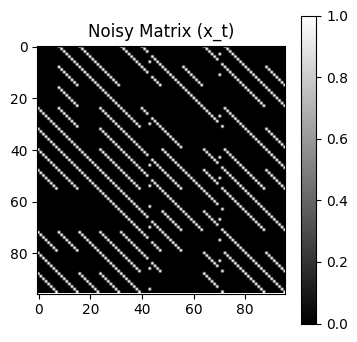

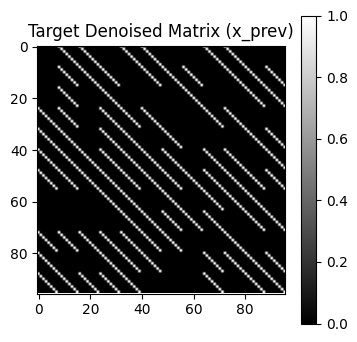

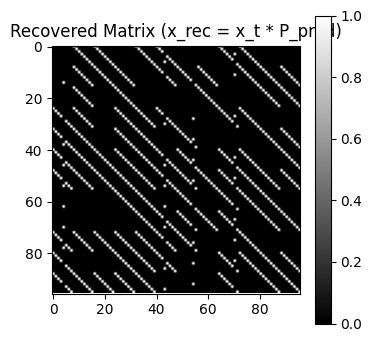

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# -------------------------------
# Set random seeds for reproducibility
# -------------------------------
np.random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# Utility: display matrix (image)
# -------------------------------
def show_matrix(matrix, title="Matrix"):
    plt.figure(figsize=(4,4))
    plt.imshow(matrix, cmap='gray', vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    plt.show()

# -------------------------------
# Generate a clean 96x96 partial-diagonal matrix.
# The matrix is divided into 144 (12x12) blocks (each 8x8).
# A random number n (in [n_low, n_high]) of these blocks are filled with an 8x8 identity.
# -------------------------------
def generate_diagonal_matrix(n=None, n_low=40, n_high=100, show=False):
    if n is None:
        n = np.random.randint(n_low, n_high+1)
    a = np.zeros((96, 96), dtype=np.float32)
    picked = np.random.choice(144, n, replace=False)
    count = 0
    for i in range(12):
        for j in range(12):
            if count in picked:
                a[i*8:(i+1)*8, j*8:(j+1)*8] = np.eye(8, dtype=np.float32)
            count += 1
    if show:
        show_matrix(a, title=f"Clean Partial Diagonal Matrix (n={n})")
    return a

# -------------------------------
# Noise process: apply a single column-swap.
# -------------------------------
def generate_swap_permutation():
    """
    Generates a 96x96 permutation matrix corresponding to swapping two randomly chosen columns.
    """
    P = np.eye(96, dtype=np.float32)
    i, j = np.random.choice(96, 2, replace=False)
    P[:, [i, j]] = P[:, [j, i]]
    return P, (min(i,j), max(i,j))  # return also the swapped pair (ordered)

def apply_swap(x):
    P, swap_pair = generate_swap_permutation()
    x_swapped = np.dot(x, P)
    return x_swapped, P, swap_pair

def forward_process_with_last(x0, t):
    """
    For our RL setting we assume t>=1 so that one swap is applied.
    (If t>1 you could apply multiple swaps; here we keep it simple.)
    """
    # For t>=1, we just apply one swap:
    x_t, P_target, swap_target = apply_swap(x0)
    return x_t, x0, P_target, swap_target

# -------------------------------
# Helper: convert a permutation matrix to a permutation vector.
# For a 96x96 permutation matrix P, v[j]=i if the jth column has a 1 in row i.
# -------------------------------
def permutation_matrix_to_vector(P):
    return np.argmax(P, axis=0)

# -------------------------------
# Helper: given a permutation matrix from a single swap, extract the swap pair.
# For a matrix P that is identity except for one swap, there will be exactly two columns j with np.argmax(P[:,j]) != j.
# -------------------------------
def get_swap_pair(P):
    swap = []
    for j in range(P.shape[1]):
        i = np.argmax(P[:, j])
        if i != j:
            swap.append((i, j))
    # In a single swap, you might see the pair twice; return unique pair.
    indices = set()
    for a, b in swap:
        indices.add(a)
        indices.add(b)
    indices = list(indices)
    indices.sort()
    if len(indices) == 2:
        return (indices[0], indices[1])
    else:
        return None

# -------------------------------
# Dataset for the RL setting.
# For each sample:
#   - Generate a clean matrix x0.
#   - Apply one swap to get x_t and record the target swap pair.
#   - x_prev is the clean matrix (since only one swap was applied).
# -------------------------------
class RLPermutationDiffusionDataset(Dataset):
    def __init__(self, num_samples, n_low=40, n_high=100):
        self.num_samples = num_samples
        self.n_low = n_low
        self.n_high = n_high

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        x0 = generate_diagonal_matrix(n=None, n_low=self.n_low, n_high=self.n_high, show=False)
        x0 = (x0 > 0.5).astype(np.float32)
        # Apply one swap to create noise:
        x_t, x_prev, P_target, swap_target = forward_process_with_last(x0, t=1)
        # Add channel dimension: shape becomes (1, 96, 96)
        x_t = np.expand_dims(x_t, axis=0)
        x_prev = np.expand_dims(x_prev, axis=0)
        return (torch.tensor(x_t, dtype=torch.float32),
                torch.tensor(x_prev, dtype=torch.float32),
                torch.tensor(swap_target, dtype=torch.long))  # target swap pair (tuple of two ints)

# -------------------------------
# RL Policy Network.
#
# This network takes the noisy matrix x_t (shape: batch x 1 x 96 x 96) and produces
# two distributions (over 96 columns) for selecting the two columns to swap.
# The network uses a shared CNN encoder and then two separate linear heads.
# -------------------------------
class RLPolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Shared CNN encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 96->48
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 48->24
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),# 24->12
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 12 * 12, 512)
        self.relu = nn.ReLU()
        # Two heads for predicting first and second swap indices
        self.head1 = nn.Linear(512, 96)
        self.head2 = nn.Linear(512, 96)

    def forward(self, x):
        """
        x: noisy matrix, shape (batch, 1, 96, 96)
        Returns:
            logits1: (batch, 96) for first index,
            logits2: (batch, 96) for second index.
        """
        features = self.encoder(x)
        features = self.flatten(features)
        features = self.relu(self.fc(features))
        logits1 = self.head1(features)  # no activation; will use softmax
        logits2 = self.head2(features)
        return logits1, logits2

    def sample_action(self, x):
        """
        Given input x (batch, 1, 96, 96), sample a pair of column indices (a, b)
        such that a != b.
        Returns:
            action: tensor of shape (batch, 2) with the chosen indices.
            log_prob: tensor of shape (batch,) with sum of log probabilities.
        """
        logits1, logits2 = self.forward(x)  # each: (batch, 96)
        probs1 = torch.softmax(logits1, dim=1)
        batch_size = x.shape[0]
        actions = []
        log_probs = []
        for i in range(batch_size):
            # Sample first index:
            dist1 = torch.distributions.Categorical(probs1[i])
            a = dist1.sample()
            log_p1 = dist1.log_prob(a)
            # For second head, mask out the chosen index
            logits2_i = logits2[i]
            mask = torch.ones_like(logits2_i, dtype=torch.bool)
            mask[a] = False
            # Set logits for masked index to a very low value:
            logits2_i_masked = logits2_i.clone()
            logits2_i_masked[~mask] = -1e9
            probs2 = torch.softmax(logits2_i_masked, dim=0)
            dist2 = torch.distributions.Categorical(probs2)
            b = dist2.sample()
            log_p2 = dist2.log_prob(b)
            actions.append(torch.stack([a, b]))
            log_probs.append(log_p1 + log_p2)
        actions = torch.stack(actions)  # shape (batch, 2)
        log_probs = torch.stack(log_probs)  # shape (batch,)
        return actions, log_probs

# -------------------------------
# Given an action (swap pair), build the corresponding binary permutation matrix.
# That is, P_pred is the identity with columns a and b swapped.
# -------------------------------
def build_permutation_matrix_from_action(action, dim=96):
    # action is a pair [a, b]
    P = np.eye(dim, dtype=np.float32)
    a, b = action
    P[:, [a, b]] = P[:, [b, a]]
    return P

# -------------------------------
# Define the reward: here we swap the predicted columns in x_t and compare with x_prev.
# We use negative MSE so that lower error (better recovery) gives a higher (less negative) reward.
# -------------------------------
mse_loss_fn = nn.MSELoss()

def compute_reward(x_t, x_prev, action):
    # x_t and x_prev are torch tensors of shape (batch, 1, 96, 96)
    # For each sample in the batch, build the permutation matrix from the action,
    # apply it to x_t (squeezed to (batch, 96, 96)), and compute negative MSE with x_prev.
    batch_size = x_t.shape[0]
    rewards = []
    x_t_flat = x_t.squeeze(1)  # (batch, 96, 96)
    x_prev_flat = x_prev.squeeze(1)
    for i in range(batch_size):
        act = action[i].cpu().numpy()  # [a, b]
        P_pred = build_permutation_matrix_from_action(act, dim=96)
        # Convert P_pred to torch tensor
        P_pred_t = torch.tensor(P_pred, dtype=torch.float32, device=device)
        # Recovered matrix:
        x_rec = torch.matmul(x_t_flat[i], P_pred_t)
        loss_val = mse_loss_fn(x_rec, x_prev_flat[i])
        reward = -loss_val  # higher reward for lower loss
        rewards.append(reward)
    rewards = torch.stack(rewards)  # shape (batch,)
    return rewards

# -------------------------------
# Training routine using REINFORCE.
# We update the policy network using the policy gradient:
#    loss = - (log_prob * (reward - baseline))
# We use a simple running average as a baseline.
# -------------------------------
def train_rl_policy(num_epochs=20, batch_size=16, learning_rate=1e-3, num_samples=1000):
    dataset = RLPermutationDiffusionDataset(num_samples=num_samples)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    policy_net = RLPolicyNetwork().to(device)
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    baseline = None  # running average of reward

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_rewards = []
        for x_t, x_prev, target_swap in dataloader:
            x_t = x_t.to(device)   # (batch, 1, 96, 96)
            x_prev = x_prev.to(device)
            # Sample action and get log probability:
            actions, log_probs = policy_net.sample_action(x_t)  # actions: (batch,2), log_probs: (batch,)
            rewards = compute_reward(x_t, x_prev, actions)  # (batch,)
            # Update baseline (simple moving average)
            batch_reward = rewards.mean().item()
            if baseline is None:
                baseline = batch_reward
            else:
                baseline = 0.9 * baseline + 0.1 * batch_reward
            # Compute policy loss:
            advantage = rewards - baseline  # (batch,)
            loss = - (log_probs * advantage).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_rewards.append(batch_reward)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader):.4f}, Avg Reward: {np.mean(epoch_rewards):.4f}")
    return policy_net

# -------------------------------
# Evaluation: For a single test sample, let the policy sample an action.
# Then print the predicted swap pair and corresponding binary permutation matrix,
# along with the target swap pair (from the known forward swap) and its permutation matrix.
# Also show the clean, noisy, target denoised, and recovered matrices.
# -------------------------------
def evaluate_policy(policy_net, noise_level=1, show=True):
    # For our setting noise_level is fixed to 1 swap.
    # Get one test sample.
    dataset = RLPermutationDiffusionDataset(num_samples=1)
    x_t, x_prev, target_swap = dataset[0]
    # x_t, x_prev: (1, 96, 96); target_swap: (2,) (tensor)
    x_t = x_t.to(device).unsqueeze(0)    # shape: (1,1,96,96)
    x_prev = x_prev.to(device).unsqueeze(0)
    # Use the policy network to sample an action.
    policy_net.eval()
    with torch.no_grad():
        actions, _ = policy_net.sample_action(x_t)
    action = actions[0].cpu().numpy()  # predicted swap pair (two indices)
    # Build predicted permutation matrix:
    P_pred = build_permutation_matrix_from_action(action, dim=96)
    # Also get target permutation matrix. (The dataset produced x_t by applying one swap.)
    # Recreate it here by comparing x_t (noisy) and x_prev (target). In our single-swap setting,
    # the target permutation is the unique swap that was applied.
    # (We assume that the dataset's target_swap (tensor) contains the correct pair.)
    target_swap = target_swap.numpy()  # e.g. [a, b] with a < b
    P_target = np.eye(96, dtype=np.float32)
    a, b = target_swap
    P_target[:, [a, b]] = P_target[:, [b, a]]
    
    # Recover the matrix using the predicted swap:
    x_t_np = x_t.cpu().squeeze().numpy()
    x_prev_np = x_prev.cpu().squeeze().numpy()
    x_rec = np.dot(x_t_np, P_pred)
    
    print("Predicted swap pair (columns to swap):", action)
    print("Predicted permutation matrix (binary):")
    print(P_pred)
    print("Target swap pair:", target_swap)
    print("Target permutation matrix:")
    print(P_target)
    
    if show:
        show_matrix(x_t_np, title="Noisy Matrix (x_t)")
        show_matrix(x_prev_np, title="Target Denoised Matrix (x_prev)")
        show_matrix(x_rec, title="Recovered Matrix (x_rec = x_t * P_pred)")
    return action, target_swap

# -------------------------------
# Main function: train the RL policy and then evaluate it.
# -------------------------------
def main():
    policy_net = train_rl_policy(num_epochs=20, batch_size=16, learning_rate=1e-3, num_samples=1000)
    evaluate_policy(policy_net, noise_level=1, show=True)

if __name__ == "__main__":
    main()